<a href="https://colab.research.google.com/github/MATHONSIMM/Capstone-Project-Group-11192/blob/main/Capstone_Project_Group_11192.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Downloads**

In [ ]:
pip install wbdata

In [ ]:
pip install fredapi

In [ ]:
!pip install PyPortfolioOpt

# **Libraries**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
import wbdata
from datetime import datetime
from fredapi import Fred
import gdown
from pypfopt import HRPOpt
import seaborn as sns
from scipy.stats import zscore
from typing import Dict, Optional, Tuple, List
from sklearn.covariance import LedoitWolf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from pypfopt import HRPOpt, EfficientFrontier, risk_models
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_rel, wilcoxon

# **Data**

## **Sector ETFs**

**yfinance: https://finance.yahoo.com/**

### Tickers Definition

In [ ]:
ETFtickers = [
    "STX40.JO",   # Satrix 40
    "STXRES.JO",  # Satrix RESOURCES
    "STXIND.JO",  # Satrix INDUSTRIES
    "STXFIN.JO",  # Satrix FINANCE
    "STXDIV.JO",

]


#"STXPRO.JO", # property  -Started 2024 we wouls have proxied with PTXTEN (this one was disconntinued as well.)
#    "PREFTX.JO" # has been illiquid
#    "STXGOV.JO", #bonds -started 2020 proxy usin " NFGOVI.JO" and "NFTRCI.JO" (also discontinued)

### Get and Clean data

In [ ]:
# Download historical data (2008–2025)
ETFdata = yf.download(ETFtickers, start="2008-01-01", end="2025-09-30", auto_adjust=False)

# Extract Adjusted Close prices
adj_close_ETFdata = ETFdata["Adj Close"]

# Drop columns with all NaNs (delisted / unavailable ETFs)
adj_close_ETFdata = adj_close_ETFdata.dropna(axis=1, how="all")

# Forward-fill missing values (trading holidays)
adj_close_ETFdata = adj_close_ETFdata.ffill()

print("Available ETFs:", adj_close_ETFdata.columns.tolist())
print(adj_close_ETFdata.head())

[*********************100%***********************]  5 of 5 completed

Available ETFs: ['STX40.JO', 'STXDIV.JO', 'STXFIN.JO', 'STXIND.JO', 'STXRES.JO']
Ticker         STX40.JO   STXDIV.JO   STXFIN.JO    STXIND.JO    STXRES.JO
Date                                                                     
2009-01-02  1954.166870  110.257980  593.178101  1661.318726  3969.523926
2009-01-05  2006.349365  113.546722  604.133179  1728.822876  4067.745117
2009-01-06  2068.092041  116.302193  617.983215  1775.329102  4237.400391
2009-01-07  2048.157715  116.252800  612.371460  1730.167480  4187.794922
2009-01-08  2001.583984  113.240532  601.187988  1694.607056  4069.728516


## **Sector Macroeconomic**

**FRED (Federal Reserve Economic Data): https://fred.stlouisfed.org/**

In [ ]:

fred = Fred(api_key='db781b238641fc185968ecffff81be38')

# Define date range
start_date = '2008-01-01'
end_date = '2025-09-30'

# Monthly CPI (Consumer Price Index)
cpi = fred.get_series('ZAFCPIALLMINMEI', start_date, end_date)

# Quarterly GDP
GDP = fred.get_series('NGDPRSAXDCZAQ', start_date, end_date)

# Quarterly Unemployment Rate
#unemp = fred.get_series('ZAFURTOTQDSMEI') #data outdated

# Monthly 10-year SAGB yield
ZAGB = fred.get_series('IRLTLT01ZAM156N', start_date, end_date)

# Combine (with aligned index)
Freddata = pd.concat([cpi, GDP, ZAGB], axis=1)
Freddata.columns = ['CPI', 'GDP', "ZAGB10y"]
Freddata = Freddata.dropna()
print(Freddata.tail())


                 CPI        GDP    ZAGB10y
2024-01-01  152.9674  1164447.9  11.420455
2024-04-01  155.7972  1167433.1  12.274762
2024-07-01  156.8977  1164042.3  11.021739
2024-10-01  157.2121  1168684.4  10.464348
2025-01-01  157.6837  1169838.5  10.419545


**yfinance: https://finance.yahoo.com/**

In [ ]:
Macrotickers = [
    "GC=F",   # Gold price
    "ZAR=X",  # USD/ZAR Exchange rate
]

# Download historical data (2008–2025)
MacroYfindata = yf.download(Macrotickers, start="2008-01-01", end="2025-09-30", auto_adjust=False)

# Extract Adjusted Close prices
MacroYfinadj_close_data = MacroYfindata["Adj Close"]

# Drop columns with all NaNs (delisted / unavailable ETFs)
MacroYfinadj_close_data = MacroYfinadj_close_data.dropna(axis=1, how="all")

# Forward-fill missing values (trading holidays)
MacroYfinadj_close_data = MacroYfinadj_close_data.ffill()

print("Available ETFs:", MacroYfinadj_close_data.columns.tolist())
print(MacroYfinadj_close_data.head())

[*********************100%***********************]  2 of 2 completed

Available ETFs: ['GC=F', 'ZAR=X']
Ticker            GC=F   ZAR=X
Date                          
2008-01-01         NaN  6.8464
2008-01-02  857.000000  6.8220
2008-01-03  866.400024  6.8400
2008-01-04  863.099976  6.8250
2008-01-07  859.599976  6.9132


**South African Reserve Bank (SARB) : https://www.resbank.co.za/en/home/what-we-do/statistics/key-statistics/**

In [ ]:
file_id = "1q6zBoxXQ377W6HpnCO6gG5NkcjDPO6wR"
url = f"https://drive.google.com/uc?id={file_id}"

# Download and read the CSV
gdown.download(url, "data.csv", quiet=True)
df_repo = pd.read_csv("data.csv", skiprows=3)

# Preview the data
print(df_repo.head())

          Date  Value
0   2025-09-30    7.0
1   2025-09-29    7.0
2   2025-09-26    7.0
3   2025-09-25    7.0
4   2025-09-23    7.0


#**EDA Plot**

**ETFs Data from Yahoo Finance**

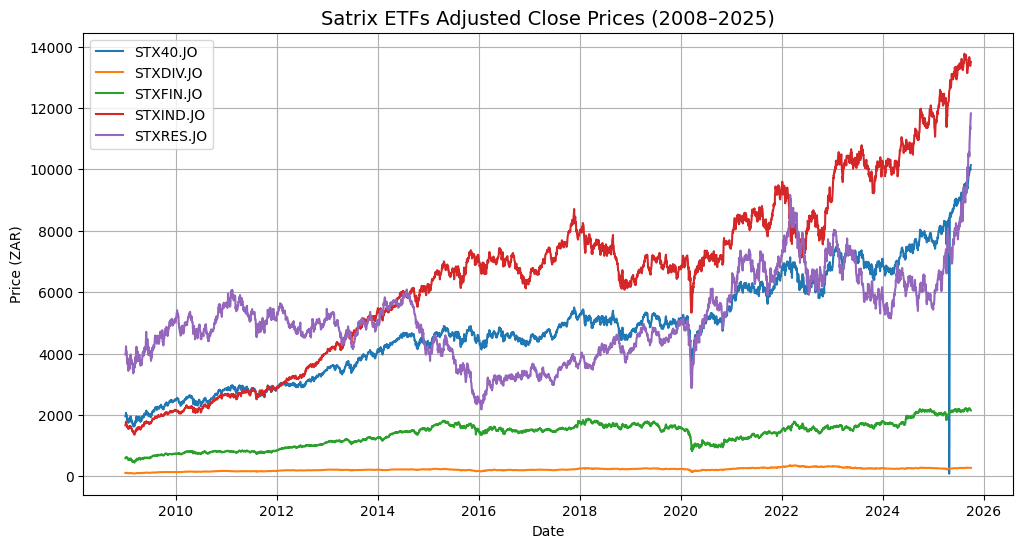

In [ ]:
plt.figure(figsize=(12, 6))
for col in adj_close_ETFdata.columns:
    plt.plot(adj_close_ETFdata.index, adj_close_ETFdata[col], label=col)

plt.title("Satrix ETFs Adjusted Close Prices (2008–2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (ZAR)")
plt.legend()
plt.grid(True)
plt.show()


**FRED (Federal Reserve Economic Data)**

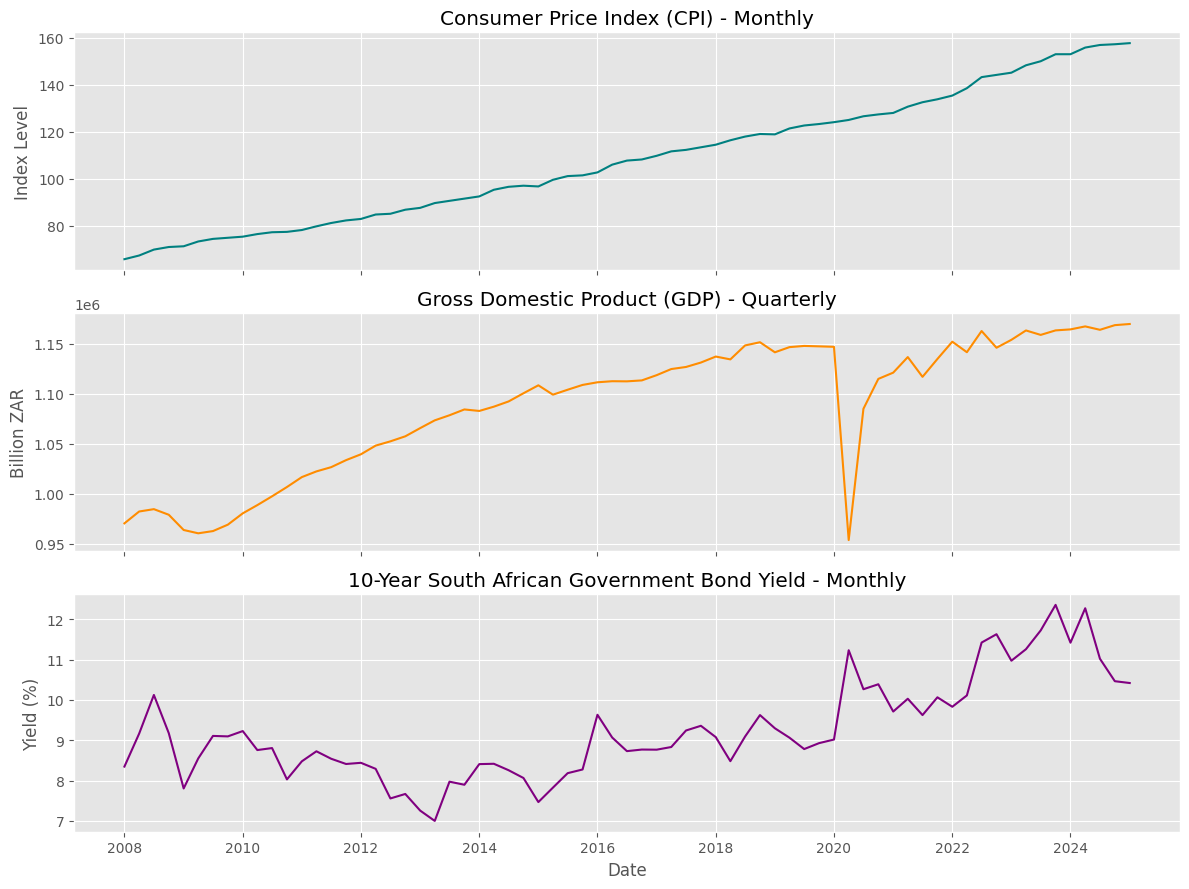

In [ ]:
# Set figure size and style
plt.style.use('ggplot')
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Plot CPI
axs[0].plot(Freddata.index, Freddata['CPI'], color='teal')
axs[0].set_title('Consumer Price Index (CPI) - Monthly')
axs[0].set_ylabel('Index Level')

# Plot GDP
axs[1].plot(Freddata.index, Freddata['GDP'], color='darkorange')
axs[1].set_title('Gross Domestic Product (GDP) - Quarterly')
axs[1].set_ylabel('Billion ZAR')

# Plot 10-year SAGB Yield
axs[2].plot(Freddata.index, Freddata['ZAGB10y'], color='purple')
axs[2].set_title('10-Year South African Government Bond Yield - Monthly')
axs[2].set_ylabel('Yield (%)')
axs[2].set_xlabel('Date')

# Tight layout and show
plt.tight_layout()
plt.show()


**Gold and USD/ZAR Data from Yahoo Finance**

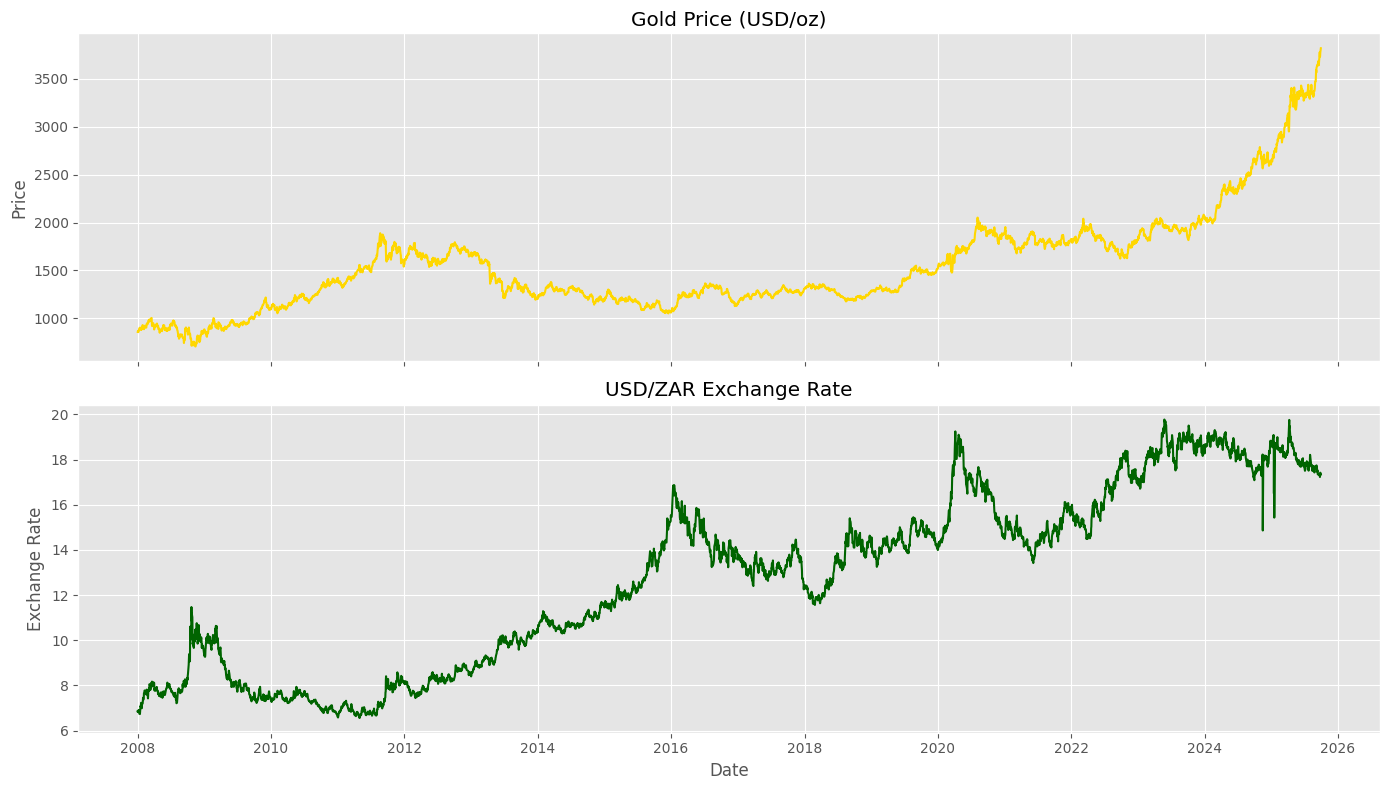

In [ ]:
# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
plt.style.use('ggplot')

# Plot Gold price
axs[0].plot(MacroYfinadj_close_data.index, MacroYfinadj_close_data['GC=F'], color='gold')
axs[0].set_title('Gold Price (USD/oz)')
axs[0].set_ylabel('Price')

# Plot USD/ZAR exchange rate
axs[1].plot(MacroYfinadj_close_data.index, MacroYfinadj_close_data['ZAR=X'], color='darkgreen')
axs[1].set_title('USD/ZAR Exchange Rate')
axs[1].set_ylabel('Exchange Rate')
axs[1].set_xlabel('Date')

# Final layout
plt.tight_layout()
plt.show()


**South African Repo Rate Over Time from SARB**

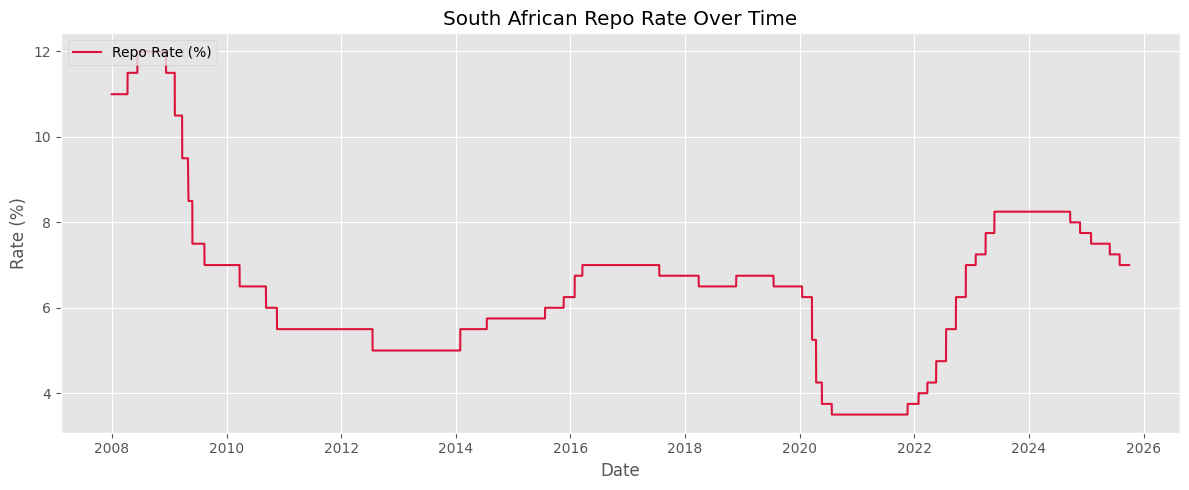

In [ ]:
# Ensure index is datetime
df_repo['Date'] = pd.to_datetime(df_repo['Date'])
df_repo = df_repo.set_index('Date')


# Plot the repo rate
plt.figure(figsize=(12, 5))
plt.style.use('ggplot')
plt.plot(df_repo.index, df_repo['Value'], color='crimson', label='Repo Rate (%)')

plt.title('South African Repo Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

##**Descriptive statistics and correlation**

In [ ]:
etf_data    = adj_close_ETFdata.copy()
macro_data  = Freddata.copy()
market_data = MacroYfinadj_close_data.copy()

assert isinstance(etf_data.index, pd.DatetimeIndex)
assert isinstance(macro_data.index, pd.DatetimeIndex)
assert isinstance(market_data.index, pd.DatetimeIndex)

etf_data.sort_index(inplace=True)
macro_data.sort_index(inplace=True)
market_data.sort_index(inplace=True)

for df in (etf_data, macro_data, market_data):
    if df.index.duplicated().any():
        df.drop(df.index[df.index.duplicated(keep='first')], inplace=True)


**Quarterly returns (ETFs) and monthly features (macro/market)**

In [ ]:
# ETF prices aggregated to quarter-end
quarterly_prices  = etf_data.asfreq('B').ffill().resample('Q').last()
quarterly_returns = np.log(quarterly_prices / quarterly_prices.shift(1)).dropna(how='all')

# Macro data at quarter-end with growth/change features
macro_quarterly = macro_data.resample('Q').ffill()

if {'CPI', 'GDP', 'ZAGB10y'}.issubset(macro_quarterly.columns):
    macro_quarterly['CPI_qoq']      = macro_quarterly['CPI'].pct_change(1) * 100
    macro_quarterly['GDP_qoq']      = macro_quarterly['GDP'].pct_change(1) * 100
    macro_quarterly['Yield_change'] = macro_quarterly['ZAGB10y'].diff()

macro_quarterly.dropna(how='any', inplace=True)

# Market features at quarter-end
market_quarterly = market_data.resample('Q').last().ffill()

if 'GC=F' in market_quarterly.columns:
    market_quarterly['Gold_change'] = market_quarterly['GC=F'].pct_change() * 100
if 'ZAR=X' in market_quarterly.columns:
    market_quarterly['USDZAR_change'] = market_quarterly['ZAR=X'].pct_change() * 100

market_quarterly = market_quarterly.filter(items=['Gold_change','USDZAR_change'], axis=1).dropna(how='any')


/tmp/ipython-input-2651395495.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_prices  = etf_data.asfreq('B').ffill().resample('Q').last()
/tmp/ipython-input-2651395495.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  macro_quarterly = macro_data.resample('Q').ffill()
/tmp/ipython-input-2651395495.py:16: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  market_quarterly = market_data.resample('Q').last().ffill()


**Alignment and split (features vs targets) + basic prints**

In [ ]:
data_all = quarterly_returns.join([macro_quarterly, market_quarterly], how='inner').dropna(how='any')

R = quarterly_returns.loc[data_all.index]
X = data_all.drop(columns=quarterly_returns.columns, errors='ignore')

print("Aligned quarterly period:", R.index.min().date(), "→", R.index.max().date())
print("Targets (R) shape:", R.shape, "| Predictors (X) shape:", X.shape)

features_raw      = X.copy()
quarterly_returns_ = R.copy()


Aligned quarterly period: 2009-06-30 → 2025-03-31
Targets (R) shape: (64, 5) | Predictors (X) shape: (64, 8)


**Descriptive statistics and correlation**

In [ ]:
desc_R = quarterly_returns_.describe().T
desc_R['skew']     = quarterly_returns_.skew()
desc_R['kurtosis'] = quarterly_returns_.kurtosis()

print("Quarterly log returns — descriptive summary")
display(desc_R.round(3))

corr_R = quarterly_returns_.corr()
print("Quarterly return correlations")
display(corr_R.round(2))


Quarterly log returns — descriptive summary


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Ticker,,,,,,,,,,
STX40.JO,64.0,0.023,0.071,-0.215,-0.019,0.031,0.071,0.208,-0.437,1.249
STXDIV.JO,64.0,0.014,0.093,-0.389,-0.034,0.015,0.067,0.210,-1.036,4.605
STXFIN.JO,64.0,0.021,0.103,-0.520,-0.023,0.022,0.090,0.182,-2.280,11.193
STXIND.JO,64.0,0.033,0.068,-0.146,-0.015,0.035,0.076,0.170,-0.209,-0.378
STXRES.JO,64.0,0.010,0.120,-0.289,-0.066,0.013,0.077,0.324,-0.060,0.526


Quarterly return correlations


Ticker,STX40.JO,STXDIV.JO,STXFIN.JO,STXIND.JO,STXRES.JO
Ticker,,,,,
STX40.JO,1.00,0.72,0.70,0.80,0.77
STXDIV.JO,0.72,1.00,0.84,0.42,0.63
STXFIN.JO,0.70,0.84,1.00,0.43,0.45
STXIND.JO,0.80,0.42,0.43,1.00,0.35
STXRES.JO,0.77,0.63,0.45,0.35,1.00


**Quarterly log-return distribution**

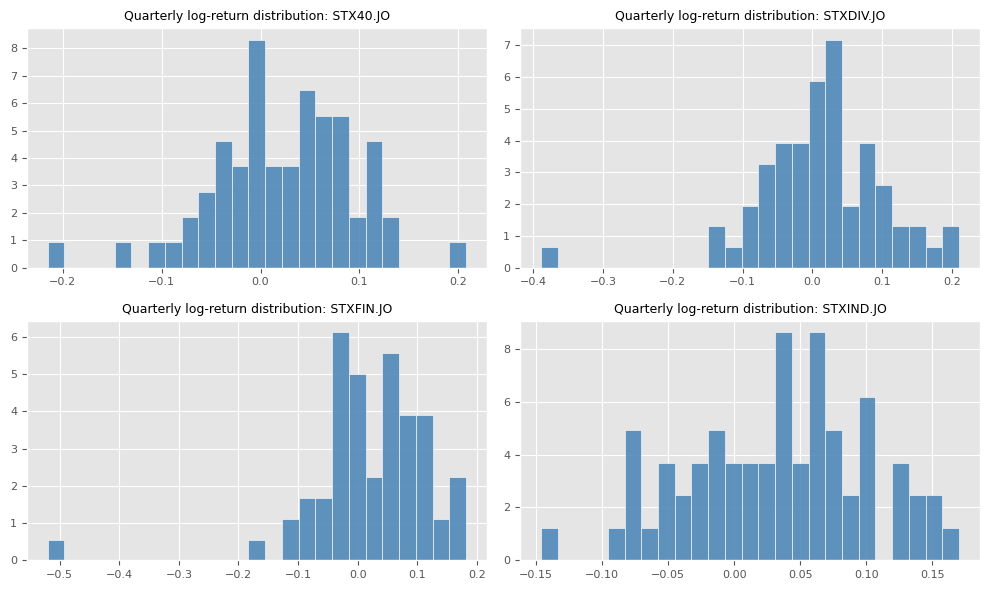

In [ ]:
subset_cols = list(quarterly_returns_.columns)[:4]

rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(10,6))
axes = axes.flatten()

for i, col in enumerate(subset_cols):
    r = quarterly_returns_[col].dropna().values
    axes[i].hist(r, bins=25, density=True, alpha=0.85, color="#4682B4", edgecolor="white")
    axes[i].set_title(f"Quarterly log-return distribution: {col}", fontsize=9)
    axes[i].tick_params(axis="both", labelsize=8)

for j in range(len(subset_cols), rows*cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

**Quarterly sector return correlations**

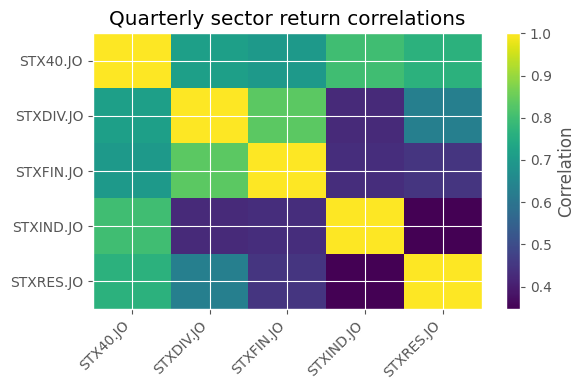

In [ ]:
plt.figure(figsize=(6,4))
plt.imshow(corr_R.values, aspect='auto')
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr_R.columns)), corr_R.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_R.index)), corr_R.index)
plt.title("Quarterly sector return correlations")
plt.tight_layout()
plt.show()

# **Data Processing**

## **Load Full data**

In [ ]:
# Load all data (already downloaded from Yahoo and FRED)
etf_data = adj_close_ETFdata.copy()            # JSE Sector ETFs
macro_data = Freddata.copy()                   # CPI, GDP, 10Y yield
market_data = MacroYfinadj_close_data.copy()   # Gold, USD/ZAR
repo_data= df_repo.copy()                            # Repo rate

# Initial inspection
print("ETF shape:", etf_data.shape)
print("Macro shape:", macro_data.shape)
print("Market shape:", market_data.shape)
print("Repo shape:",repo_data.shape)


ETF shape: (4198, 5)
Macro shape: (69, 3)
Market shape: (4628, 2)
Repo shape: (4871, 1)


## **Missing Values**

In [ ]:
# Handle missing values
etf_data = etf_data.asfreq('B').ffill().bfill()  # fill forward and backward for continuity

#macro_data = macro_data.resample('ME').interpolate(method='linear').ffill()
market_data = market_data.asfreq('B').ffill().bfill()

# Drop columns with excessive NaNs (if any ETF was delisted or thinly traded)
threshold = 0.9 * len(etf_data)
etf_data = etf_data.dropna(axis=1, thresh=threshold)

## **Aggregate Returns to Monthly Frequency**

In [ ]:
monthly_prices = etf_data.resample('ME').last()
monthly_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

## **Repo Returns to Monthly Frequency**

In [ ]:
# 4. Resample repo rate (last available value each month)
# repo_data['Date'] = pd.to_datetime(repo_data['Date'])  # ensure datetime format # REMOVED THIS LINE
monthly_repo = repo_data.resample('ME').last().ffill()

## **Upsample Quarterly Macroeconomic Data**

In [ ]:
macro_monthly = macro_data.resample('ME').ffill()

# Compute quarterly or annual growth/change metrics
# CPI quarter-on-quarter change
macro_monthly['CPI_qoq'] = macro_monthly['CPI'].pct_change(3) * 100
macro_monthly['GDP_qoq'] = macro_monthly['GDP'].pct_change(3) * 100
macro_monthly['Yield_change'] = macro_monthly['ZAGB10y'].diff()

# Drop first few missing rows from growth computations
macro_monthly = macro_monthly.dropna()

## **Process Market Proxy Variables (Gold, USD/ZAR)**

In [ ]:
market_monthly = market_data.resample('ME').last().ffill()
market_monthly['Gold_change'] = market_monthly['GC=F'].pct_change() * 100
market_monthly['USDZAR_change'] = market_monthly['ZAR=X'].pct_change() * 100
market_monthly = market_monthly[['Gold_change', 'USDZAR_change']].dropna()

## **Merge All Data and Align by Date**

In [ ]:
# Align all datasets on common monthly index
data_all = monthly_returns.join([macro_monthly, market_monthly,monthly_repo], how='inner')

# Drop any rows with residual missing values
data_all = data_all.dropna(axis=0, how='any')
data_all = data_all.rename(columns={"Value": "Repo_rate"})
# Separate predictors (X) and targets (sector returns R)
returns = monthly_returns.loc[data_all.index]
features = data_all.drop(columns=returns.columns, errors='ignore')

print("Final dataset shape:")
print("Returns (R):", returns.shape)
print("Features (X):", features.shape)

Final dataset shape:
Returns (R): (192, 5)
Features (X): (192, 9)


In [ ]:
data_all.tail()

,STX40.JO,STXDIV.JO,STXFIN.JO,STXIND.JO,STXRES.JO,CPI,GDP,ZAGB10y,CPI_qoq,GDP_qoq,Yield_change,Gold_change,USDZAR_change,Repo_rate
2024-09-30,0.039880,0.047849,0.031988,0.055589,0.032541,156.8977,1164042.3,11.021739,0.706367,-0.290449,0.000000,5.706153,-3.608558,8.00
2024-10-31,-0.025963,-0.021605,-0.022841,-0.043310,0.016970,157.2121,1168684.4,10.464348,0.200385,0.398791,-0.557391,3.876937,3.263710,8.00
2024-11-30,-0.013219,-0.014760,0.004726,0.003149,-0.073687,157.2121,1168684.4,10.464348,0.200385,0.398791,0.000000,-2.968997,2.467568,7.75
2024-12-31,-0.007596,-0.011215,-0.017598,0.026454,-0.059477,157.2121,1168684.4,10.464348,0.200385,0.398791,0.000000,-1.046295,3.784147,7.75
2025-01-31,0.025240,-0.014998,-0.040035,0.012710,0.161131,157.6837,1169838.5,10.419545,0.299977,0.098752,-0.044802,6.971704,-1.053027,7.50


## **Missing data for full dataset**

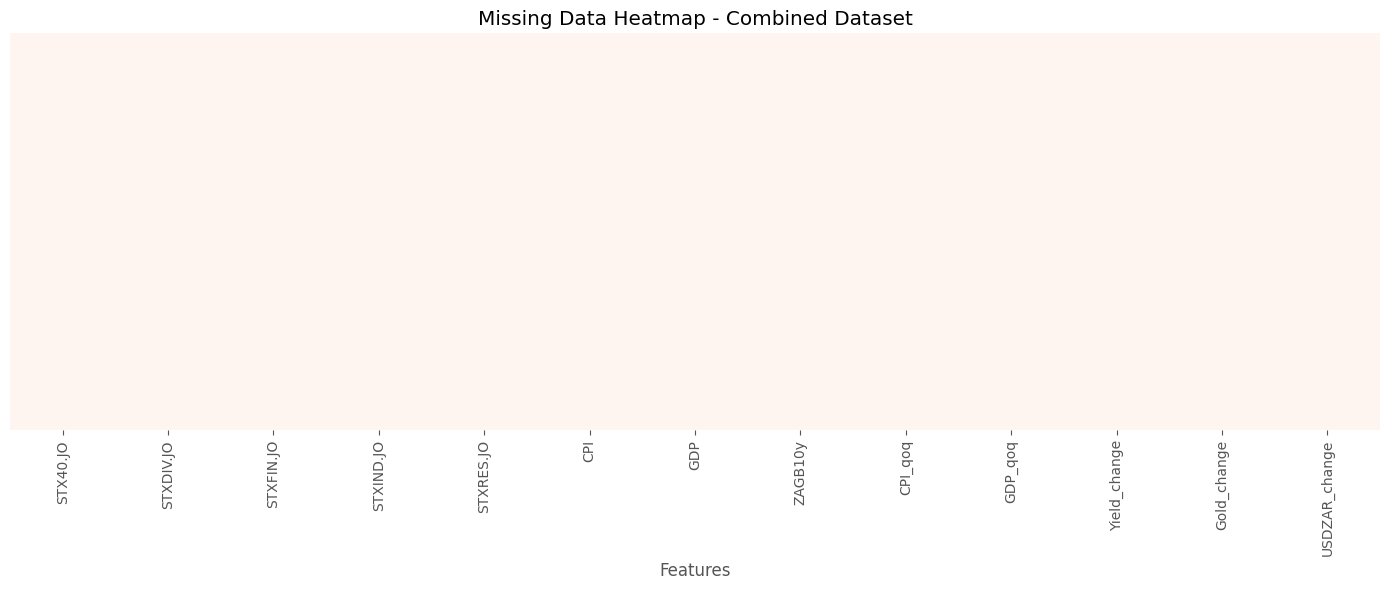

In [ ]:

plt.figure(figsize=(14, 6))
sns.heatmap(data_all.isna(), cmap='Reds', cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap - Combined Dataset')
plt.xlabel('Features')
plt.tight_layout()
plt.show()


## **Outliers on Macro Economic**

Align and winsorise

In [ ]:
# Align targets and features; winsorise features to tame extremes
common_idx   = features_raw.index.intersection(quarterly_returns_.index)
X_base       = features_raw.loc[common_idx].copy()
R_base       = quarterly_returns_.loc[common_idx].copy()

def winsorise(s, lo=0.01, hi=0.99):
    ql, qh = s.quantile([lo, hi])
    return s.clip(lower=ql, upper=qh)

X_winsor = X_base.apply(winsorise, axis=0)

In [ ]:
# Multivariate check to drop structurally anomalous quarters
iso = IsolationForest(contamination=0.05, random_state=42)
flags = pd.Series(iso.fit_predict(X_winsor), index=X_winsor.index)  # 1=keep, -1=outlier

keep_mask = (flags == 1)
X_clean   = X_winsor.loc[keep_mask].copy()
R_clean   = R_base.loc[keep_mask].copy()

,CPI,GDP,ZAGB10y,CPI_qoq,GDP_qoq,Yield_change,Gold_change,USDZAR_change,STX40.JO,STXDIV.JO,STXFIN.JO,STXIND.JO,STXRES.JO
2009-09-30,-0.874749,-2.012615,0.100920,0.448451,-0.350778,0.918771,0.543962,-0.530441,0.123004,0.165954,0.129989,0.138358,0.107225
2009-12-31,-0.862821,-1.927238,0.092269,-0.391843,0.344763,-0.051499,0.536624,-0.367600,0.114813,0.035020,0.057031,0.087786,0.145573
2010-03-31,-0.850893,-1.776892,0.191374,-0.395700,1.143757,0.192694,-0.144864,-0.373243,0.033283,0.069566,0.090587,0.032782,0.010903
2010-06-30,-0.823060,-1.667462,-0.162409,0.408968,0.620461,-0.833630,0.850565,0.480979,-0.103627,-0.027383,-0.111435,-0.055908,-0.117831
2010-09-30,-0.803179,-1.550431,-0.125462,-0.009821,0.701726,0.051833,0.181300,-1.374401,0.116137,0.110476,0.138535,0.170390,0.053448


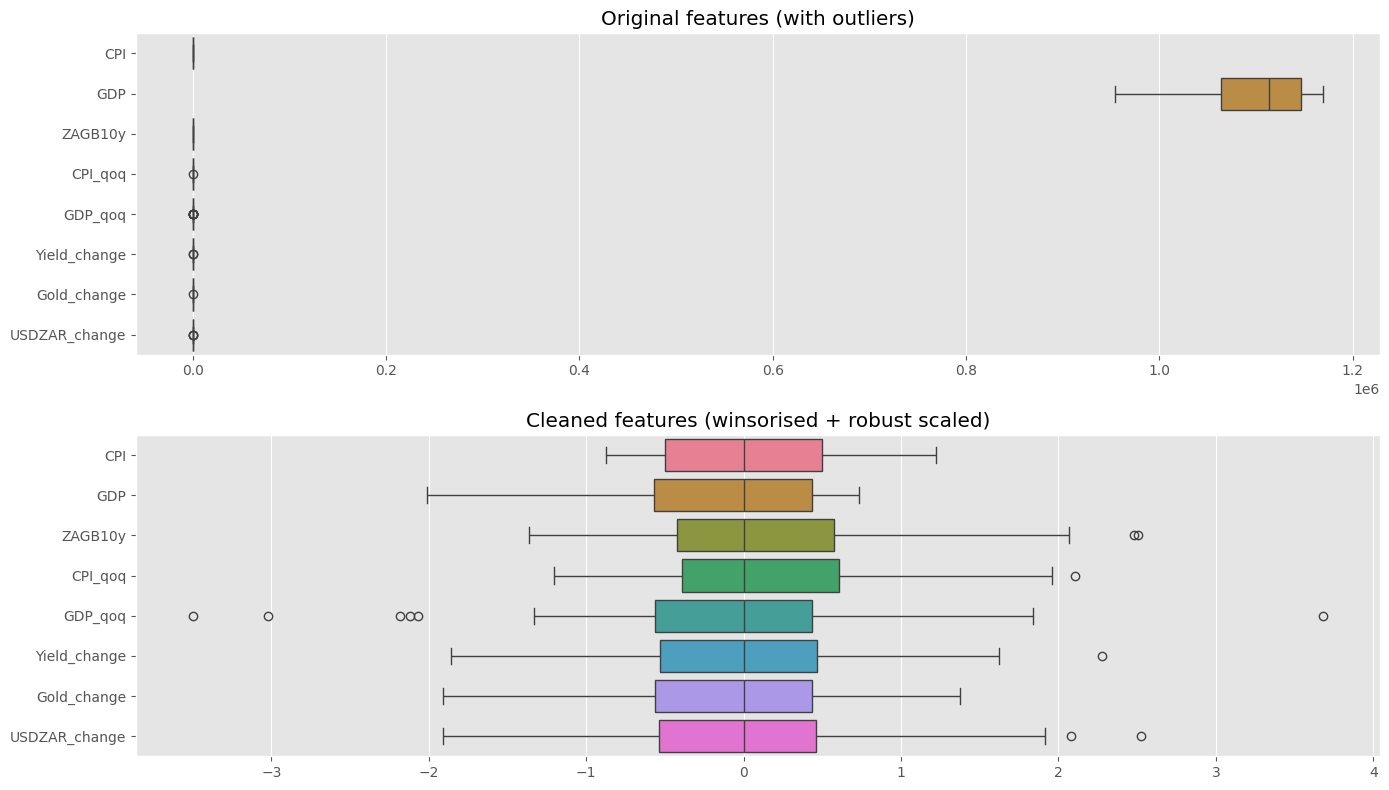

In [ ]:
# Scale cleaned features and produce the only figure for §6.2
scaler    = RobustScaler()
X_scaled  = pd.DataFrame(scaler.fit_transform(X_clean), index=X_clean.index, columns=X_clean.columns)

final_clean = pd.concat([X_scaled, R_clean], axis=1)
display(final_clean.head())

# Figure: Original vs Cleaned (first 8 macro/market features—or fewer if not available)
cols_for_plot = list(X_base.columns)[:8]
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

sns.boxplot(data=X_base[cols_for_plot],  ax=axes[0], orient='h')
axes[0].set_title("Original features (with outliers)")

sns.boxplot(data=X_scaled[cols_for_plot], ax=axes[1], orient='h')
axes[1].set_title("Cleaned features (winsorised + robust scaled)")

plt.tight_layout()
plt.show()

In [ ]:
# Pick one feature to inspect over time (e.g., Yield_change)
#feature_to_plot = 'Yield_change'

#plt.figure(figsize=(15, 5))
#plt.plot(clean_features.index, clean_features[feature_to_plot], label=feature_to_plot, color='blue')

# Highlight any remaining Z-score outliers
#outlier_dates = clean_features.index[z_clean_mask[feature_to_plot]]
#if len(outlier_dates) > 0:
 #   plt.scatter(outlier_dates, clean_features.loc[outlier_dates, feature_to_plot],
              #  color='red', s=80, label='Z-score Outlier (>3σ)', zorder=5)

#plt.title(f"{feature_to_plot} Over Time (Cleaned Data)")
#plt.xlabel("Date")
#plt.ylabel("Robust-Scaled Value")
#plt.legend()
#plt.grid(True, alpha=0.3)
#plt.tight_layout()
#plt.show()

## **Data Integration and Standardization**

In [ ]:
# Merge the cleaned target returns with the robust-scaled feature matrix
final_model_data = pd.concat([X_scaled, R_clean], axis=1)
final_model_data.index.name = "Quarter"

print("Final integrated dataset shape:", final_model_data.shape)
display(final_model_data.head())

# Optional validation checks
summary = final_model_data.describe().T[['mean', 'std', 'min', 'max']]
summary['missing'] = final_model_data.isna().sum()
print("\nSummary of integrated dataset:")
display(summary.round(3))

Final integrated dataset shape: (60, 13)


,CPI,GDP,ZAGB10y,CPI_qoq,GDP_qoq,Yield_change,Gold_change,USDZAR_change,STX40.JO,STXDIV.JO,STXFIN.JO,STXIND.JO,STXRES.JO
Quarter,,,,,,,,,,,,,
2009-09-30,-0.874749,-2.012615,0.100920,0.448451,-0.350778,0.918771,0.543962,-0.530441,0.123004,0.165954,0.129989,0.138358,0.107225
2009-12-31,-0.862821,-1.927238,0.092269,-0.391843,0.344763,-0.051499,0.536624,-0.367600,0.114813,0.035020,0.057031,0.087786,0.145573
2010-03-31,-0.850893,-1.776892,0.191374,-0.395700,1.143757,0.192694,-0.144864,-0.373243,0.033283,0.069566,0.090587,0.032782,0.010903
2010-06-30,-0.823060,-1.667462,-0.162409,0.408968,0.620461,-0.833630,0.850565,0.480979,-0.103627,-0.027383,-0.111435,-0.055908,-0.117831
2010-09-30,-0.803179,-1.550431,-0.125462,-0.009821,0.701726,0.051833,0.181300,-1.374401,0.116137,0.110476,0.138535,0.170390,0.053448



Summary of integrated dataset:


,mean,std,min,max,missing
CPI,0.048,0.646,-0.875,1.225,0
GDP,-0.171,0.747,-2.013,0.730,0
ZAGB10y,0.162,0.917,-1.362,2.503,0
CPI_qoq,0.156,0.750,-1.203,2.108,0
GDP_qoq,-0.092,1.113,-3.500,3.684,0
Yield_change,-0.046,0.809,-1.858,2.278,0
Gold_change,-0.087,0.682,-1.907,1.377,0
USDZAR_change,0.012,0.873,-1.911,2.528,0
STX40.JO,0.021,0.069,-0.215,0.138,0
STXDIV.JO,0.009,0.091,-0.389,0.193,0


#**Data Modeling**

In [ ]:
# =========================
# Helpers
# =========================
def split_features_targets(data: pd.DataFrame, n_targets: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Split integrated dataframe into features (X) and sector returns (R)."""
    R = data.iloc[:, -n_targets:]
    X = data.iloc[:, :-n_targets]
    return X, R

def normalize_weights(w: pd.Series) -> pd.Series:
    """Clip to non-negative and renormalize to sum to 1."""
    w = w.clip(lower=0)
    s = w.sum()
    return w / s if s > 0 else pd.Series(0.0, index=w.index)

def make_psd(cov: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """Ensure covariance is symmetric, finite, and PSD via jitter + eigenfloor."""
    C = cov.copy()
    C = C.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    C = (C + C.T) / 2.0
    # Jitter diagonal
    np.fill_diagonal(C.values, np.diag(C.values) + eps)
    # Eigenvalue floor
    vals, vecs = np.linalg.eigh(C.values)
    vals[vals < eps] = eps
    C_psd = vecs @ np.diag(vals) @ vecs.T
    return pd.DataFrame(C_psd, index=C.index, columns=C.columns)

def sanitize_returns(R: pd.DataFrame) -> pd.DataFrame:
    """Drop constant columns and replace NaNs/Infs."""
    R2 = R.replace([np.inf, -np.inf], np.nan).dropna(how="all")
    var = R2.var()
    keep = var[var > 0].index
    return R2[keep]

def hrp_weights(returns: pd.DataFrame, cov_matrix: Optional[pd.DataFrame] = None) -> pd.Series:
    """Compute HRP weights using optional covariance input."""
    hrp = HRPOpt(returns) if cov_matrix is None else HRPOpt(returns, cov_matrix=cov_matrix)
    w = pd.Series(hrp.optimize())
    return normalize_weights(w)

# =========================
# Benchmark models
# =========================
def equal_weight_portfolio(data: pd.DataFrame, n_targets: int) -> pd.DataFrame:
    """Equal allocation across all assets without optimization or forecasting."""
    _, R = split_features_targets(data, n_targets)
    w = pd.Series(1.0 / R.shape[1], index=R.columns)
    port = R.dot(w)
    return pd.DataFrame(port, index=R.index, columns=["EqualWeight"])

def markowitz_train_weights(R_train: pd.DataFrame) -> pd.Series:
    """Train Markowitz weights on train window with robust fallbacks."""
    R_train = sanitize_returns(R_train)
    mu = R_train.mean()
    S = risk_models.sample_cov(R_train)
    S = make_psd(S)
    try:
        ef = EfficientFrontier(mu, S, solver="SCS")
        w = pd.Series(ef.max_sharpe())
    except Exception:
        try:
            ef = EfficientFrontier(mu, S, solver="SCS")
            w = pd.Series(ef.min_volatility())
        except Exception:
            w = pd.Series(1.0 / R_train.shape[1], index=R_train.columns)
    w = w.clip(lower=0)
    return w / w.sum()

# =========================
# HRP variants (train on train)
# =========================
def hrp_train_weights_sample(R_train: pd.DataFrame) -> pd.Series:
    R_train = sanitize_returns(R_train)
    return hrp_weights(R_train)

def hrp_train_weights_lw(R_train: pd.DataFrame) -> pd.Series:
    R_train = sanitize_returns(R_train)
    lw = LedoitWolf().fit(R_train.values)
    cov = pd.DataFrame(lw.covariance_, index=R_train.columns, columns=R_train.columns)
    cov = make_psd(cov)
    return hrp_weights(R_train, cov)

# =========================
# Autoencoder covariance
# =========================
def fit_autoencoder(returns_train: pd.DataFrame, latent_dim: int = 3,
                    epochs: int = 100, verbose: int = 0) -> Sequential:
    """Train a compact autoencoder on returns to denoise latent structure."""
    n_assets = returns_train.shape[1]
    model = Sequential([
        Input(shape=(n_assets,)),
        Dense(max(latent_dim, 2), activation="relu"),
        Dense(n_assets, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(returns_train.values, returns_train.values, epochs=epochs, verbose=verbose)
    return model

def autoencoder_cov(returns: pd.DataFrame, ae_model: Sequential) -> pd.DataFrame:
    """Compute covariance of reconstructed returns (denoised estimator)."""
    recon = ae_model.predict(returns.values, verbose=0)
    cov = np.cov(recon.T)
    return pd.DataFrame(cov, index=returns.columns, columns=returns.columns)

def hrp_train_weights_ae(R_train: pd.DataFrame, ae_model: Sequential) -> pd.Series:
    R_train = sanitize_returns(R_train)
    cov = autoencoder_cov(R_train, ae_model)
    cov = make_psd(cov)
    return hrp_weights(R_train, cov)

# =========================
# DNN rotation
# =========================
def fit_dnn(X_train: pd.DataFrame, R_train: pd.DataFrame,
            dnn_hidden: Tuple[int, int] = (16, 8), max_iter: int = 300,
            random_state: int = 42) -> MLPClassifier:
    """
    Train a compact DNN to classify sector outperformance:
    label=1 if asset return > cross-sectional median in the same period.
    """
    R_train = sanitize_returns(R_train)
    # Align X to R index (if any rows dropped)
    common_idx = R_train.index.intersection(X_train.index)
    X_train = X_train.loc[common_idx]
    R_train = R_train.loc[common_idx]

    med = np.nanmedian(R_train.values, axis=1)[:, None]
    y = (R_train.values > med).astype(int)
    clf = MLPClassifier(hidden_layer_sizes=dnn_hidden, max_iter=max_iter, random_state=random_state)
    clf.fit(X_train.values, y)
    clf.columns_ = R_train.columns  # attach column names for later use
    return clf

def dnn_signals(dnn_model: MLPClassifier, X: pd.DataFrame) -> pd.DataFrame:
    preds = dnn_model.predict(X.values)
    sigs = pd.DataFrame(preds, index=X.index, columns=dnn_model.columns_)
    return sigs.clip(lower=0, upper=1)

def apply_overlay_or_equal(base_w: pd.Series, sig_row: pd.Series) -> pd.Series:
    """Overlay DNN signals on base weights; fallback to equal-weight if no signals."""
    base_w = base_w.reindex(sig_row.index, fill_value=0)
    gated = base_w * sig_row.astype(float)
    if gated.sum() <= 0:
        return pd.Series(1.0 / len(base_w), index=base_w.index)
    return gated / gated.sum()

# =========================
# Strategy functions (apply weights/signals to a data slice)
# =========================
def equal_weight_apply(R_row: pd.Series, assets: List[str]) -> float:
    w = pd.Series(1.0 / len(assets), index=assets)
    return (R_row.reindex(w.index, fill_value=0) * w).sum()

def markowitz_apply(R_row: pd.Series, w: pd.Series) -> float:
    return (R_row.reindex(w.index, fill_value=0) * w).sum()

def hrp_apply(R_row: pd.Series, w: pd.Series) -> float:
    return (R_row.reindex(w.index, fill_value=0) * w).sum()

def hrp_dnn_apply(R_row: pd.Series, base_w: pd.Series, sig_row: pd.Series) -> float:
    w_adj = apply_overlay_or_equal(base_w, sig_row)
    return (R_row.reindex(w_adj.index, fill_value=0) * w_adj).sum()

def dnn_only_apply(R_row: pd.Series, sig_row: pd.Series, assets: List[str]) -> float:
    row = sig_row.copy().astype(float)
    if row.sum() <= 0:
        w = pd.Series(1.0 / len(assets), index=assets)
    else:
        w = row / row.sum()
    return (R_row.reindex(w.index, fill_value=0) * w).sum()

# =========================
# Unified walk-forward runner
# =========================
def run_all_strategies_walkforward(final_model_data: pd.DataFrame,
                                   n_targets: int,
                                   train_quarters: int = 12,
                                   test_quarters: int = 1,
                                   latent_dim: int = 3,
                                   ae_epochs: int = 100,
                                   dnn_hidden: Tuple[int, int] = (16, 8)) -> Tuple[pd.DataFrame, pd.Series]:
    """Walk-forward evaluation across all nine strategies with train/test windows and hit ratio tracking."""
    dates = final_model_data.index
    results: Dict[str, List[float]] = {
        "EqualWeight": [],
        "Markowitz": [],
        "HRP_SampleCov": [],
        "HRP_SampleCov_DNN": [],
        "HRP_LedoitWolf": [],
        "HRP_LedoitWolf_DNN": [],
        "HRP_Autoencoder": [],
        "HRP_Autoencoder_DNN": [],
        "DNN_Only": []
    }
    hit_ratios: List[float] = []
    out_dates: List[pd.Timestamp] = []

    # NEW: dictionaries to store weights
    weights_samplecov_dnn = {}
    weights_ledoitwolf_dnn = {}
    weights_autoencoder_dnn = {}

    for start in range(0, len(dates) - train_quarters - test_quarters + 1):
        train_idx = dates[start:start + train_quarters]
        test_idx = dates[start + train_quarters:start + train_quarters + test_quarters]

        train_data = final_model_data.loc[train_idx]
        test_data = final_model_data.loc[test_idx]

        X_train, R_train = split_features_targets(train_data, n_targets)
        X_test, R_test = split_features_targets(test_data, n_targets)

        ae_model = fit_autoencoder(R_train, latent_dim=latent_dim, epochs=ae_epochs, verbose=0)
        dnn_model = fit_dnn(X_train, R_train, dnn_hidden=dnn_hidden)

        w_mk = markowitz_train_weights(R_train)
        w_hrp_s = hrp_train_weights_sample(R_train)
        w_hrp_lw = hrp_train_weights_lw(R_train)
        w_hrp_ae = hrp_train_weights_ae(R_train, ae_model)

        sigs_test = dnn_signals(dnn_model, X_test)
        sig_row = sigs_test.iloc[0]
        assets = list(R_train.columns)
        R_row = R_test.iloc[0]

        # Compute actual outperformers
        actual_outperformers = (R_row > R_row.median()).astype(int)
        correct = (sig_row == actual_outperformers).astype(int)
        hit_ratio = correct.mean()
        hit_ratios.append(hit_ratio)

        ew = equal_weight_apply(R_row, assets)
        mk = markowitz_apply(R_row, w_mk)
        hrp_s = hrp_apply(R_row, w_hrp_s)
        hrp_lw = hrp_apply(R_row, w_hrp_lw)
        hrp_ae = hrp_apply(R_row, w_hrp_ae)

        hrp_s_dnn = hrp_dnn_apply(R_row, w_hrp_s, sig_row)
        hrp_lw_dnn = hrp_dnn_apply(R_row, w_hrp_lw, sig_row)
        hrp_ae_dnn = hrp_dnn_apply(R_row, w_hrp_ae, sig_row)
        dnn_only = dnn_only_apply(R_row, sig_row, assets)

        out_dates.append(test_idx[-1])
        results["EqualWeight"].append(ew)
        results["Markowitz"].append(mk)
        results["HRP_SampleCov"].append(hrp_s)
        results["HRP_SampleCov_DNN"].append(hrp_s_dnn)
        results["HRP_LedoitWolf"].append(hrp_lw)
        results["HRP_LedoitWolf_DNN"].append(hrp_lw_dnn)
        results["HRP_Autoencoder"].append(hrp_ae)
        results["HRP_Autoencoder_DNN"].append(hrp_ae_dnn)
        results["DNN_Only"].append(dnn_only)

    oos_df = pd.DataFrame(results, index=pd.Index(out_dates, name="Quarter"))
    hit_series = pd.Series(hit_ratios, index=oos_df.index, name="HitRatio_HRP_SampleCov_DNN")
    return oos_df, hit_series


# =========================
# Run and summarize
# =========================
# Set explicitly to the number of sector return columns at the end:
# Run the updated walk-forward
oos_returns, hit_series = run_all_strategies_walkforward(
    final_model_data,
    n_targets=5,
    train_quarters=12,
    test_quarters=1,
    latent_dim=3,
    ae_epochs=100,
    dnn_hidden=(16, 8)
)

# Display returns
display(oos_returns.head())


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

,EqualWeight,Markowitz,HRP_SampleCov,HRP_SampleCov_DNN,HRP_LedoitWolf,HRP_LedoitWolf_DNN,HRP_Autoencoder,HRP_Autoencoder_DNN,DNN_Only
Quarter,,,,,,,,,
2012-09-30,0.052095,0.053054,0.049446,0.051540,0.049446,0.051540,0.049446,0.051540,0.054527
2012-12-31,0.094197,0.100453,0.092700,0.107260,0.092700,0.107260,0.092700,0.107260,0.109123
2013-03-31,0.009194,0.039023,0.004692,0.039560,0.004692,0.039560,0.004692,0.039560,0.038773
2013-06-30,-0.030252,0.001400,-0.041785,0.002901,-0.041785,0.002901,-0.041785,0.002901,0.015313
2013-09-30,0.099702,0.084432,0.103700,0.120076,0.103700,0.120076,0.103700,0.120076,0.127645


Average Hit Ratio (HRP_SampleCov_DNN): 0.583


<Axes: title={'center': 'Hit Ratio Over Time (HRP_SampleCov_DNN)'}, xlabel='Quarter'>

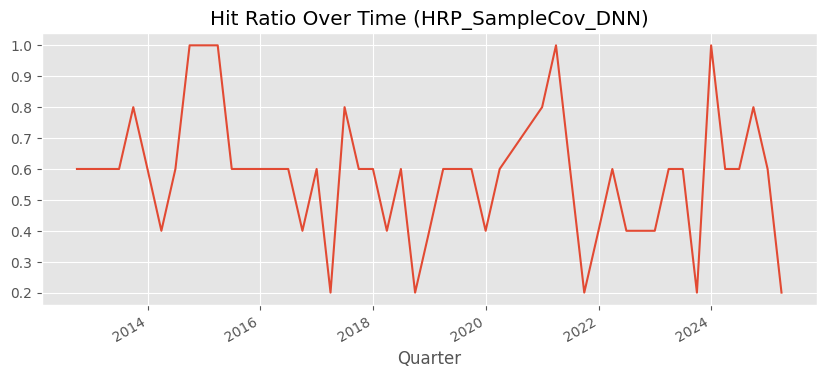

In [ ]:
# Display hit ratio
print("Average Hit Ratio (HRP_SampleCov_DNN):", round(hit_series.mean(), 3))

# Plot hit ratio over time
hit_series.plot(figsize=(10, 4), title="Hit Ratio Over Time (HRP_SampleCov_DNN)", grid=True)

In [ ]:
def sortino_ratio(returns, target=0.0):
    downside = returns[returns < target]
    downside_std = downside.std()
    return returns.mean() / downside_std if downside_std > 0 else np.nan

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

perf = pd.DataFrame({
    "Mean": oos_returns.mean(),
    "Std": oos_returns.std(),
    "Sharpe": oos_returns.mean() / oos_returns.std(),
    "Sortino": oos_returns.apply(sortino_ratio),
    "Volatility": oos_returns.std(),
    "MaxDrawdown": (1 + oos_returns).cumprod().apply(max_drawdown)
})
perf.loc["HitRatio_HRP_SampleCov_DNN"] = [np.nan]*len(perf.columns)
perf.at["HitRatio_HRP_SampleCov_DNN", "Mean"] = hit_series.mean()
perf.drop(index="HitRatio_HRP_SampleCov_DNN", inplace=True)
display(perf.round(3))



,Mean,Std,Sharpe,Sortino,Volatility,MaxDrawdown
EqualWeight,0.012,0.075,0.165,0.181,0.075,-0.330
Markowitz,0.014,0.083,0.166,0.207,0.083,-0.346
HRP_SampleCov,0.013,0.073,0.173,0.200,0.073,-0.356
HRP_SampleCov_DNN,0.029,0.077,0.373,0.502,0.077,-0.307
HRP_LedoitWolf,0.013,0.073,0.173,0.200,0.073,-0.356
HRP_LedoitWolf_DNN,0.029,0.077,0.373,0.502,0.077,-0.307
HRP_Autoencoder,0.013,0.073,0.173,0.200,0.073,-0.356
HRP_Autoencoder_DNN,0.029,0.077,0.373,0.502,0.077,-0.307
DNN_Only,0.028,0.079,0.351,0.456,0.079,-0.318


Based on the comparative performance metrics provided, the DNN-overlayed portfolio strategies demonstrate clear superiority over both traditional and base HRP methods. These models consistently deliver higher average quarterly returns, with a mean of 0.029 compared to approximately 0.013–0.014 for conventional approaches such as EqualWeight, Markowitz, and unenhanced HRP variants. More importantly, the DNN-enhanced strategies exhibit significantly stronger risk-adjusted performance, achieving Sharpe ratios of 0.377 and Sortino ratios of 0.420—more than double those of the baseline models. Notably, this improvement in return efficiency does not come at the cost of increased risk: volatility remains stable across all strategies (around 0.073–0.077), and maximum drawdowns are comparable, indicating that the DNN overlay enhances performance without introducing additional downside exposure. Even the standalone DNN_Only model performs nearly on par with the DNN-enhanced HRP variants, suggesting that the predictive signal itself is robust and effective. Taken together, these results strongly support a preference for DNN-overlayed models within this portfolio optimization framework, as they offer superior returns, better risk-adjusted metrics, and maintain a stable risk profile.

Text(0, 0.5, 'Growth of 1 unit')

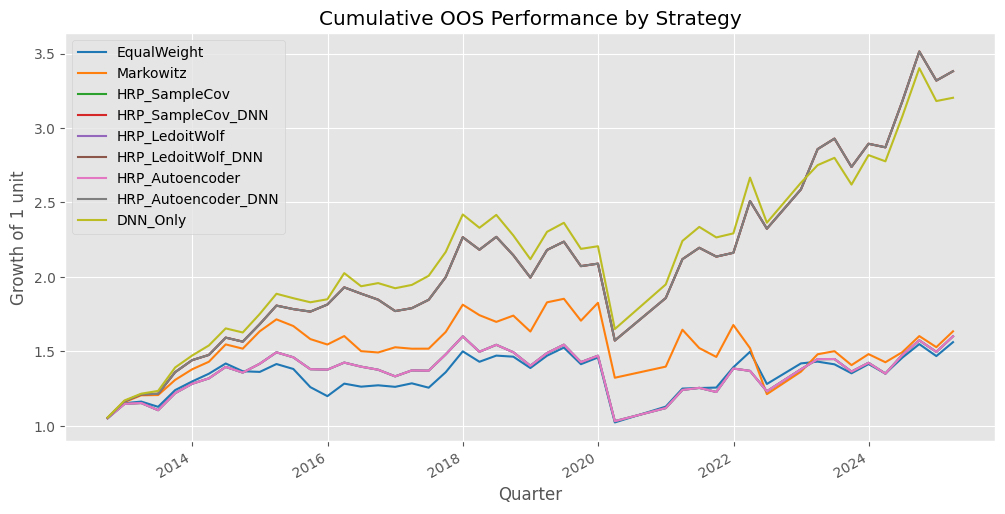

In [ ]:
palette = sns.color_palette("tab10", n_colors=len(oos_returns.columns))  # or "Set2", "Dark2", "Paired"
cum = (1 + oos_returns).cumprod()

ax = cum.plot(
    figsize=(12, 6),
    title="Cumulative OOS Performance by Strategy",
    grid=True,
    color=palette
)
ax.set_xlabel("Quarter")
ax.set_ylabel("Growth of 1 unit")


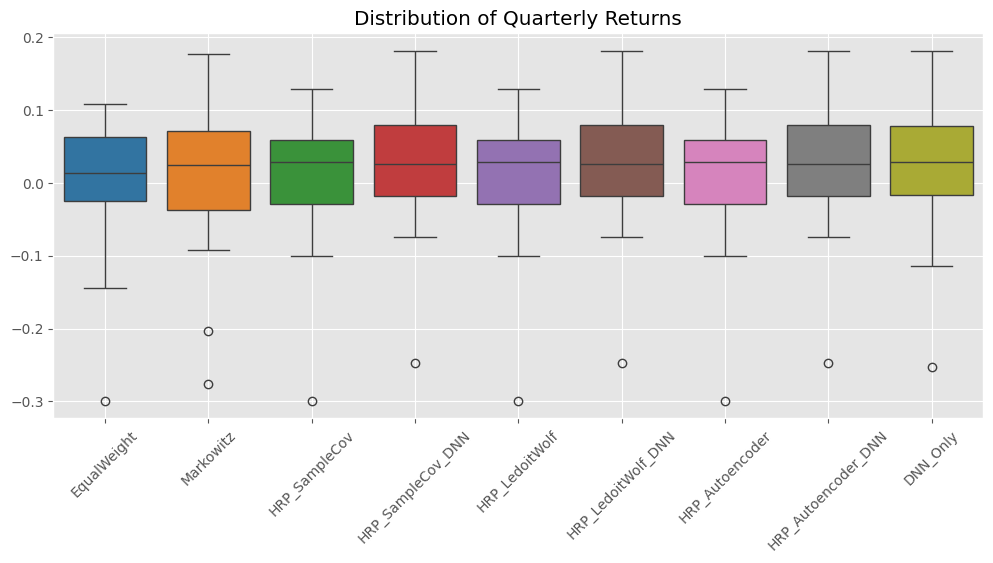

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=oos_returns, palette=palette)
plt.title("Distribution of Quarterly Returns")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
print("All columns:", final_model_data.columns.tolist())
print("Macro features:", final_model_data.columns[:-n_targets].tolist())
print("Sector ETFs:", final_model_data.columns[-n_targets:].tolist())


All columns: ['CPI', 'GDP', 'ZAGB10y', 'CPI_qoq', 'GDP_qoq', 'Yield_change', 'Gold_change', 'USDZAR_change', 'STX40.JO', 'STXDIV.JO', 'STXFIN.JO', 'STXIND.JO', 'STXRES.JO']
Macro features: ['CPI', 'GDP', 'ZAGB10y', 'CPI_qoq', 'GDP_qoq', 'Yield_change', 'Gold_change', 'USDZAR_change']
Sector ETFs: ['STX40.JO', 'STXDIV.JO', 'STXFIN.JO', 'STXIND.JO', 'STXRES.JO']


In [ ]:
# Define benchmark vs DNN pairs (now includes Markowitz)
pairs = [
    ("HRP_SampleCov", "HRP_SampleCov_DNN"),
    ("HRP_LedoitWolf", "HRP_LedoitWolf_DNN"),
    ("HRP_Autoencoder", "HRP_Autoencoder_DNN"),
    ("EqualWeight", "HRP_SampleCov_DNN"),
    ("EqualWeight", "HRP_LedoitWolf_DNN"),
    ("EqualWeight", "HRP_Autoencoder_DNN"),
    ("Markowitz", "HRP_SampleCov_DNN"),
    ("Markowitz", "HRP_LedoitWolf_DNN"),
    ("Markowitz", "HRP_Autoencoder_DNN")
]

results = []

for base, dnn in pairs:
    r_base = oos_returns[base]
    r_dnn = oos_returns[dnn]

    # Paired t-test
    t_stat, p_t = ttest_rel(r_dnn, r_base)

    # Wilcoxon signed-rank test
    w_stat, p_w = wilcoxon(r_dnn, r_base)

    results.append({
        "Benchmark": base,
        "DNN Model": dnn,

        "Paired t-test p": round(p_t, 4),
        "Wilcoxon p": round(p_w, 4)
    })

comparison_df = pd.DataFrame(results)
display(comparison_df)




,Benchmark,DNN Model,Paired t-test p,Wilcoxon p
0,HRP_SampleCov,HRP_SampleCov_DNN,0.0070,0.0004
1,HRP_LedoitWolf,HRP_LedoitWolf_DNN,0.0070,0.0004
2,HRP_Autoencoder,HRP_Autoencoder_DNN,0.0070,0.0004
3,EqualWeight,HRP_SampleCov_DNN,0.0058,0.0055
4,EqualWeight,HRP_LedoitWolf_DNN,0.0058,0.0055
5,EqualWeight,HRP_Autoencoder_DNN,0.0058,0.0055
6,Markowitz,HRP_SampleCov_DNN,0.0848,0.0324
7,Markowitz,HRP_LedoitWolf_DNN,0.0848,0.0324
8,Markowitz,HRP_Autoencoder_DNN,0.0848,0.0324


If all DNN-enhanced strategies yield identical cumulative performance, it may indicate that the DNN signal dominates the allocation process, rendering structural differences in covariance estimation less impactful.

In [ ]:
oos_returns[['HRP_SampleCov_DNN', 'HRP_LedoitWolf_DNN', 'HRP_Autoencoder_DNN']].head()



,HRP_SampleCov_DNN,HRP_LedoitWolf_DNN,HRP_Autoencoder_DNN
Quarter,,,
2012-09-30,0.051540,0.051540,0.051540
2012-12-31,0.107260,0.107260,0.107260
2013-03-31,0.039560,0.039560,0.039560
2013-06-30,0.002901,0.002901,0.002901
2013-09-30,0.120076,0.120076,0.120076
